In [1]:
import cv2 as cv
import numpy as np
import os
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
from skimage.measure import shannon_entropy
import pyfeats
import pandas as pd
import multiprocessing as mlp
import math
import feature_extraction as fe

## Define Feature Extraction functions

### Read dataset images

In [2]:
def read_images(folder = "dataset/train",
                classes = [
                            "normal",
                            "fatty",
#                             "cirrhosis"
                        ]):
    image_names = {}
    images = []
    # Get all image names in folders
    for cls in classes:
        image_names[cls] = os.listdir(f'{folder}/{cls}')

    # read all images to list
    for cls in classes:
        for name in image_names[cls]:
            img = cv.imread(f'{folder}/{cls}/{name}', cv.IMREAD_GRAYSCALE)
            images.append((img,cls))
    return images

### Extract ROIs from image

In [3]:
def extract_roi(img, start , size = (32,32)):
    roi = img[start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
    mask = np.zeros(img.shape)
    mask[start[0]:start[0]+size[0],start[1]:start[1]+size[1]] = 1
    return roi, mask

### Extract Features from ROIs

In [4]:
def feature_extraction(img):
    roi_pos = [
        (160,230),
        (118,224),
        (241,151),
        (120,420),
        (170,300),
        (400,200),
        (300,120),
        (240,240),
        (360,160)
    ]
    
    roi_mask_arr = []
    for pos in roi_pos:
        roi_mask_arr.append(extract_roi(img, pos))
    
    # 0 45 90 135 degrees
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    
    da_dict = {
        0: "d1_0",
        1: "d1_45",
        2: "d1_90",
        3: "d1_135",
        
        4: "d2_0",
        5: "d2_45",
        6: "d2_90",
        7: "d2_135",
        
        8: "d3_0",
        9: "d3_45",
        10: "d3_90",
        11: "d3_135",
        
    }
    
    feat_arr = []
    for roi, mask in roi_mask_arr:
        if 0 in roi or roi.shape != (32,32) or 0 in image.shape:
            continue
        features = {}
        
        glcm_mtx = greycomatrix(roi, distances = [1,2,3], angles = angles, levels = 256)
        con = greycoprops(glcm_mtx, 'contrast').flatten()
        hom = greycoprops(glcm_mtx, 'homogeneity').flatten()
        en = greycoprops(glcm_mtx, 'energy').flatten()
        corr = greycoprops(glcm_mtx, 'correlation').flatten()
        
        for j in range(len(da_dict)):
            features[f'contrast_{da_dict[j]}'] = con[j]
            features[f'homogeneity_{da_dict[j]}'] = hom[j]
            features[f'energy_{da_dict[j]}'] = en[j]
            features[f'correlation_{da_dict[j]}'] = corr[j]
            
        features[f'entropy'] = shannon_entropy(roi)

        feat, labels = pyfeats.glrlm_features(img, mask, 256)
        for i in range(len(labels)):
            features[labels[i]] = feat[i]
#         glrlm = {l : f for l,f in zip(labels,feat)}
#         features[f'longRunEmphasis'] = glrlm['GLRLM_LongRunEmphasis']
#         features[f'runPercentage'] = glrlm['GLRLM_RunPercentage']
        
        feat_arr.append(features)
        
    return feat_arr

### Construct dataframe from ROI features

In [5]:
def build_dataframe(images):
    # dataframe consists of features of 1 ROI per image
    # column name roiNum_feature
    data = pd.DataFrame()

    for img, cls in images:
        feat_arr = feature_extraction(img)
        for row in feat_arr:
            row['target'] = cls
            data = data.append(row,ignore_index=True)
    return data

### Construct dataframe using multiprocessing
### Reduced runtime by 82%

In [6]:
def build_with_mlp(images, n=9): 
    pool = mlp.Pool(n)
    results = pool.map(fe.build_dataframe,np.array_split(images,n))
    return results

## Feature Analysis and Selection

### Read data

In [7]:
%%time

images = fe.read_images()
mlp_data = build_with_mlp(images)
data = pd.DataFrame()
for frame in mlp_data:
    data = data.append(frame)

# images = read_images()

# data = build_dataframe(images)

# data40 = pd.read_csv('dataset/roi_40img_9_roi_3d_4a_32p.csv')
# data55 = pd.read_csv('dataset/roi_55img_9_roi_3d_4a_32p.csv')
# data = data40.append(data55, ignore_index=True)

# data = pd.read_csv('dataset/roi_95img_9_roi_glrlm_32p.csv')

# data = data[data['contrast_d1_0'] != 0]

data.describe()

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Wall time: 3min 22s


,GLRLM_GrayLevelNo-Uniformity,GLRLM_HighGrayLevelRunEmphasis,GLRLM_LongRunEmphasis,GLRLM_LongRunHighGrayLevelEmphasis,GLRLM_LongRunLowGrayLevelEmphasis,GLRLM_LowGrayLevelRunEmphasis,GLRLM_RunLengthNonUniformity,GLRLM_RunPercentage,GLRLM_Short owGrayLevelEmphasis,GLRLM_ShortRunEmphasis,...,homogeneity_d1_45,homogeneity_d1_90,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90
count,538.000000,538.000000,538.000000,538.000000,538.0,5.380000e+02,538.000000,538.000000,5.380000e+02,538.000000,...,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,1925.232105,5774.272061,1.503124,10155.578381,1.0,2.518575e+13,121919.002542,0.843519,2.518575e+13,0.941320,...,0.172105,0.147955,0.157370,0.134351,0.172105,0.108392,0.125869,0.107984,0.118957,0.103620
std,524.995394,2437.493587,0.321007,2859.686127,0.0,4.062464e+13,19505.427337,0.140850,4.062464e+13,0.024265,...,0.099986,0.080487,0.092244,0.073891,0.099986,0.067247,0.075835,0.068726,0.072770,0.069491
min,1078.202338,1464.268635,1.284691,4608.793048,1.0,1.240330e+12,102848.447946,0.707023,1.240330e+12,0.886683,...,0.054134,0.059946,0.053075,0.049359,0.054134,0.039637,0.043536,0.034124,0.037732,0.031738
25%,1500.073308,3733.833612,1.304044,7717.184507,1.0,1.334575e+12,104618.309135,0.711475,1.334575e+12,0.922127,...,0.099556,0.090622,0.084655,0.073377,0.099556,0.062077,0.070193,0.058787,0.068558,0.056954
50%,1865.672812,5520.229130,1.336752,9688.416212,1.0,6.943478e+12,105921.335451,0.715179,6.943478e+12,0.959842,...,0.143184,0.115324,0.119014,0.118352,0.143184,0.080068,0.090022,0.088096,0.093659,0.074901
75%,2382.670557,7578.758296,1.559836,12182.917893,1.0,3.035861e+13,136428.268996,0.981161,3.035861e+13,0.962491,...,0.216489,0.188462,0.214921,0.173649,0.216489,0.135791,0.168660,0.132393,0.146854,0.130552
max,3590.511843,11461.201056,3.137791,18661.048823,1.0,2.950940e+14,157672.709448,1.079653,2.950940e+14,0.965812,...,0.576049,0.515312,0.565827,0.457325,0.576049,0.417440,0.480954,0.443175,0.436596,0.401612


In [8]:
# data.to_csv("dataset/roi_95img_9_roi_glrlm_32p.csv",index = False)

### Mutual information score

In [58]:
from sklearn.preprocessing import StandardScaler

X = data.copy()
y = X.pop('target')

std = StandardScaler()
std.fit(X)
X = pd.DataFrame(std.transform(X),columns=X.columns)

In [59]:
X.describe()

,GLRLM_GrayLevelNo-Uniformity,GLRLM_HighGrayLevelRunEmphasis,GLRLM_LongRunEmphasis,GLRLM_LongRunHighGrayLevelEmphasis,GLRLM_LongRunLowGrayLevelEmphasis,GLRLM_LowGrayLevelRunEmphasis,GLRLM_RunLengthNonUniformity,GLRLM_RunPercentage,GLRLM_Short owGrayLevelEmphasis,GLRLM_ShortRunEmphasis,...,homogeneity_d1_45,homogeneity_d1_90,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90
count,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,538.0,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,...,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02,5.380000e+02
mean,-2.377281e-16,1.741688e-16,-3.755773e-17,4.820597e-16,0.0,1.888205e-17,-7.689017e-16,1.362809e-15,1.888205e-17,-1.072253e-15,...,2.424228e-16,-8.499500e-18,5.968996e-17,-2.946837e-16,2.424228e-16,5.277687e-17,3.262441e-16,6.397196e-17,8.318934e-17,-1.033869e-16
std,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,0.0,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,...,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00,1.000931e+00
min,-1.614906e+00,-1.769857e+00,-6.810933e-01,-1.941453e+00,0.0,-5.899796e-01,-9.786150e-01,-9.699961e-01,-5.899796e-01,-2.253755e+00,...,-1.180962e+00,-1.094486e+00,-1.131683e+00,-1.151311e+00,-1.180962e+00,-1.023370e+00,-1.086685e+00,-1.075713e+00,-1.117237e+00,-1.035374e+00
25%,-8.105871e-01,-8.378842e-01,-6.207489e-01,-8.534724e-01,0.0,-5.876575e-01,-8.877937e-01,-9.383596e-01,-5.876575e-01,-7.917221e-01,...,-7.262608e-01,-7.129943e-01,-7.890173e-01,-8.259583e-01,-7.262608e-01,-6.893664e-01,-7.348471e-01,-7.165112e-01,-6.932228e-01,-6.721702e-01
50%,-1.135528e-01,-1.043200e-01,-5.187615e-01,-1.635134e-01,0.0,-4.494625e-01,-8.209282e-01,-9.120360e-01,-4.494625e-01,7.640534e-01,...,-2.895172e-01,-4.058053e-01,-4.161967e-01,-2.167261e-01,-2.895172e-01,-4.215715e-01,-4.731358e-01,-2.896627e-01,-3.479632e-01,-4.136580e-01
75%,8.721299e-01,7.409930e-01,1.768346e-01,7.095976e-01,0.0,1.274514e-01,7.445502e-01,9.781318e-01,1.274514e-01,8.733124e-01,...,4.443143e-01,5.037351e-01,6.244829e-01,5.323386e-01,4.443143e-01,4.078167e-01,5.647896e-01,3.554949e-01,3.837148e-01,3.879305e-01
max,3.174941e+00,2.335277e+00,5.097043e+00,2.977035e+00,0.0,6.650138e+00,1.834719e+00,1.678052e+00,6.650138e+00,1.010317e+00,...,4.043760e+00,4.568446e+00,4.432118e+00,4.375034e+00,4.043760e+00,4.599968e+00,4.686688e+00,4.881752e+00,4.369056e+00,4.292229e+00


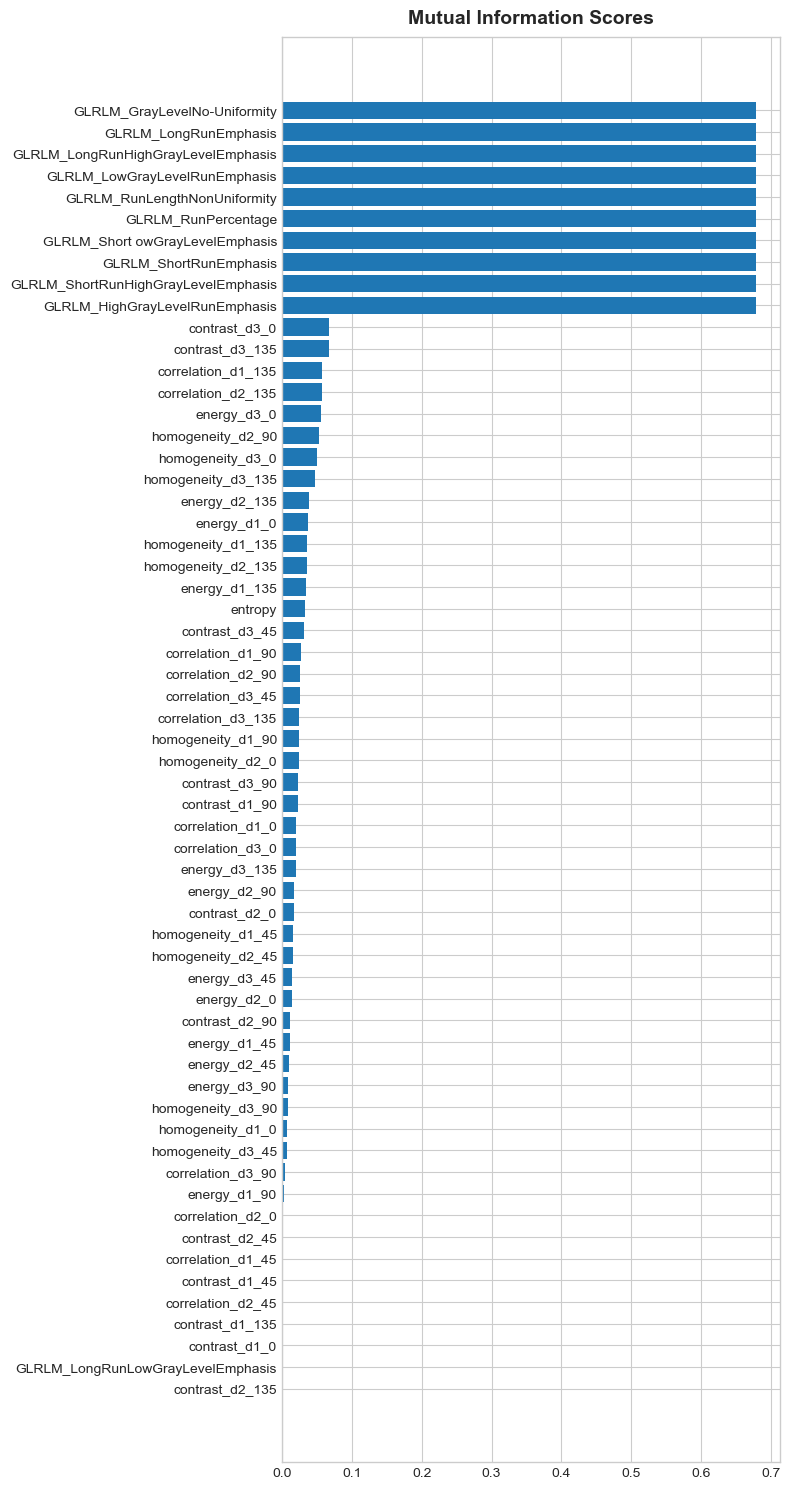

In [60]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

## Train Predictions and Scores

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X,y)

y_pred = rf.predict(X)

accuracy_score(y, y_pred)

1.0

In [62]:
from sklearn.metrics import classification_report

report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision  recall  f1-score  support
fatty               1.0     1.0       1.0    316.0
normal              1.0     1.0       1.0    222.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    538.0
weighted avg        1.0     1.0       1.0    538.0


In [63]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X,y)

y_pred = dt.predict(X)

accuracy_score(y, y_pred)

1.0

In [64]:
report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision  recall  f1-score  support
fatty               1.0     1.0       1.0    316.0
normal              1.0     1.0       1.0    222.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    538.0
weighted avg        1.0     1.0       1.0    538.0


In [65]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X,y)

y_pred = svc.predict(X)

accuracy_score(y, y_pred)

0.7620817843866171

In [66]:
report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.747368  0.898734  0.816092  316.000000
normal         0.797468  0.567568  0.663158  222.000000
accuracy       0.762082  0.762082  0.762082    0.762082
macro avg      0.772418  0.733151  0.739625  538.000000
weighted avg   0.768042  0.762082  0.752985  538.000000


## Test Predictions and Scores

In [17]:
%%time
test_images = fe.read_images("dataset/test")
mlp_test_data = build_with_mlp(test_images)

test_data = pd.DataFrame()
for frame in mlp_test_data:
    test_data = test_data.append(frame)
test_data.describe()

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Wall time: 47.7 s


,GLRLM_GrayLevelNo-Uniformity,GLRLM_HighGrayLevelRunEmphasis,GLRLM_LongRunEmphasis,GLRLM_LongRunHighGrayLevelEmphasis,GLRLM_LongRunLowGrayLevelEmphasis,GLRLM_LowGrayLevelRunEmphasis,GLRLM_RunLengthNonUniformity,GLRLM_RunPercentage,GLRLM_Short owGrayLevelEmphasis,GLRLM_ShortRunEmphasis,...,homogeneity_d1_45,homogeneity_d1_90,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90
count,114.000000,114.000000,114.000000,114.000000,114.0,1.140000e+02,114.000000,114.000000,1.140000e+02,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,1903.946076,5371.710352,1.472699,9556.628554,1.0,2.062657e+13,126918.040225,0.875497,2.062657e+13,0.939439,...,0.190564,0.161031,0.171177,0.145738,0.190564,0.121638,0.136812,0.120364,0.132531,0.117174
std,420.951375,1743.432747,0.180305,1912.487578,0.0,1.691116e+13,17877.257511,0.131548,1.691116e+13,0.019281,...,0.106736,0.078074,0.086657,0.068175,0.106736,0.067190,0.071393,0.067250,0.076055,0.069441
min,1061.252459,3914.446757,1.288211,7516.926090,1.0,1.243992e+12,103365.102908,0.707909,1.243992e+12,0.918801,...,0.066058,0.068746,0.058558,0.046886,0.066058,0.044400,0.046755,0.037139,0.040142,0.039434
25%,1688.037278,4088.271309,1.298737,8089.978417,1.0,1.561496e+12,105090.662445,0.712104,1.561496e+12,0.922239,...,0.103642,0.094917,0.090070,0.080329,0.103642,0.065961,0.073897,0.067267,0.072608,0.064385
50%,1865.239006,4790.254984,1.523177,8445.810661,1.0,2.817421e+13,135266.932348,0.947234,2.817421e+13,0.925840,...,0.168007,0.145468,0.160182,0.145143,0.168007,0.101065,0.124574,0.113933,0.109772,0.097475
75%,2223.748641,6595.428845,1.551953,11191.496754,1.0,2.925953e+13,140571.590221,0.986328,2.925953e+13,0.962412,...,0.254397,0.217960,0.228532,0.188054,0.254397,0.160640,0.180768,0.150438,0.172394,0.149905
max,2549.296693,10202.813696,1.943695,14619.311165,1.0,5.927014e+13,149313.519267,1.031691,5.927014e+13,0.964516,...,0.548980,0.406083,0.394530,0.359026,0.548980,0.373591,0.358710,0.369174,0.402374,0.381117


In [67]:
X_test = test_data.copy()
y_test = X_test.pop('target')

std = StandardScaler()
std.fit(X_test)
X_test = pd.DataFrame(std.transform(X_test),columns=X_test.columns)

In [68]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7807017543859649

In [69]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.810127  0.864865  0.836601   74.000000
normal         0.714286  0.625000  0.666667   40.000000
accuracy       0.780702  0.780702  0.780702    0.780702
macro avg      0.762206  0.744932  0.751634  114.000000
weighted avg   0.776498  0.780702  0.776975  114.000000


In [70]:
y_pred = dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.5701754385964912

In [71]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.698413  0.594595  0.642336   74.000000
normal         0.411765  0.525000  0.461538   40.000000
accuracy       0.570175  0.570175  0.570175    0.570175
macro avg      0.555089  0.559797  0.551937  114.000000
weighted avg   0.597834  0.570175  0.578898  114.000000


In [72]:
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.631578947368421

In [73]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score     support
fatty          0.690476  0.783784  0.734177   74.000000
normal         0.466667  0.350000  0.400000   40.000000
accuracy       0.631579  0.631579  0.631579    0.631579
macro avg      0.578571  0.566892  0.567089  114.000000
weighted avg   0.611947  0.631579  0.616922  114.000000


In [74]:
# Predict image using ROI predictions (majority function)